# Exploratory Data Analysis and Regression on Student Data

## 1. Introduction

Fuel efficiency (measured as mpg, miles per gallon) is a critical factor for car buyers and environmental sustainability. This project aims to predict a car’s mpg based on its characteristics such as engine_size, year, transmission, and make.

We explore these relationships through:

Data cleaning and preparation

Exploratory data analysis (EDA)

Regression modeling (linear, multiple, interactions, polynomial, log-transform)

Model diagnostics and validation

Predictions for new cars

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
df = pd.read_csv("car_prices.csv")

print(df.head())
print(df.info())
print(df.describe())


   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motors ameri

In [3]:
# Convert sale date to datetime
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')

# Drop duplicates and rows with missing target
df = df.drop_duplicates()
df = df.dropna(subset=['sellingprice'])

# Fill missing numeric values with median
num_cols = ['odometer', 'mmr', 'condition']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with mode
cat_cols = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior', 'seller', 'state']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_36984/3026841303.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_36984/3026841303.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')


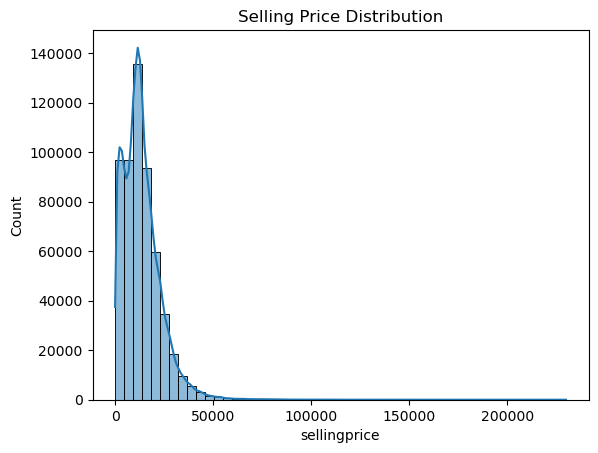

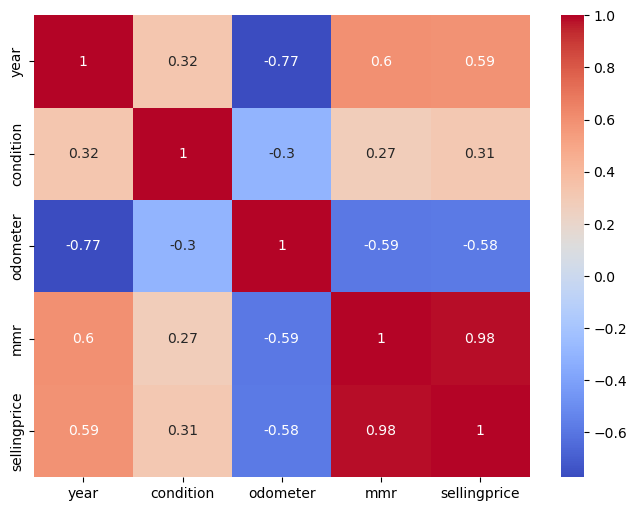

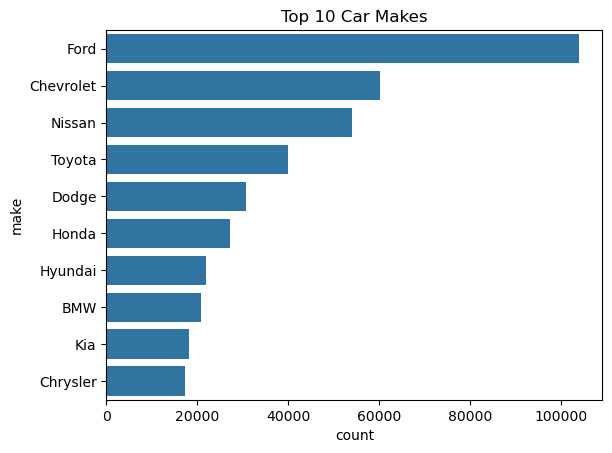

In [4]:
# Distribution of target
sns.histplot(df['sellingprice'], bins=50, kde=True)
plt.title("Selling Price Distribution")
plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df[['year','condition','odometer','mmr','sellingprice']].corr(), annot=True, cmap='coolwarm')
plt.show()

# Top 10 most common car makes
sns.countplot(y='make', data=df, order=df['make'].value_counts().index[:10])
plt.title("Top 10 Car Makes")
plt.show()


In [5]:

df['car_age'] = 2025 - df['year']  


df = df.drop(columns=['vin', 'saledate'])


numeric_features = ['condition','odometer','mmr','car_age']
categorical_features = ['make','model','trim','body','transmission','color','interior','seller','state']


In [6]:
X = df.drop('sellingprice', axis=1)
y = df['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Preprocessing: scale numeric features, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [8]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression R2: 0.9706402658269447
Linear Regression RMSE: 1673.7489032707856


In [9]:
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0))])
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
print("Ridge Regression R2:", r2_score(y_test, y_pred_ridge))
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))


Ridge Regression R2: 0.9710633313431866
Ridge Regression RMSE: 1661.6460196782987


In [10]:
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso(alpha=0.1))])
lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
print("Lasso Regression R2:", r2_score(y_test, y_pred_lasso))
print("Lasso Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))


Lasso Regression R2: 0.9706649625580815
Lasso Regression RMSE: 1673.04479568558


In [11]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



Random Forest R2: 0.9720241536082774
Random Forest RMSE: 1633.8262268381627


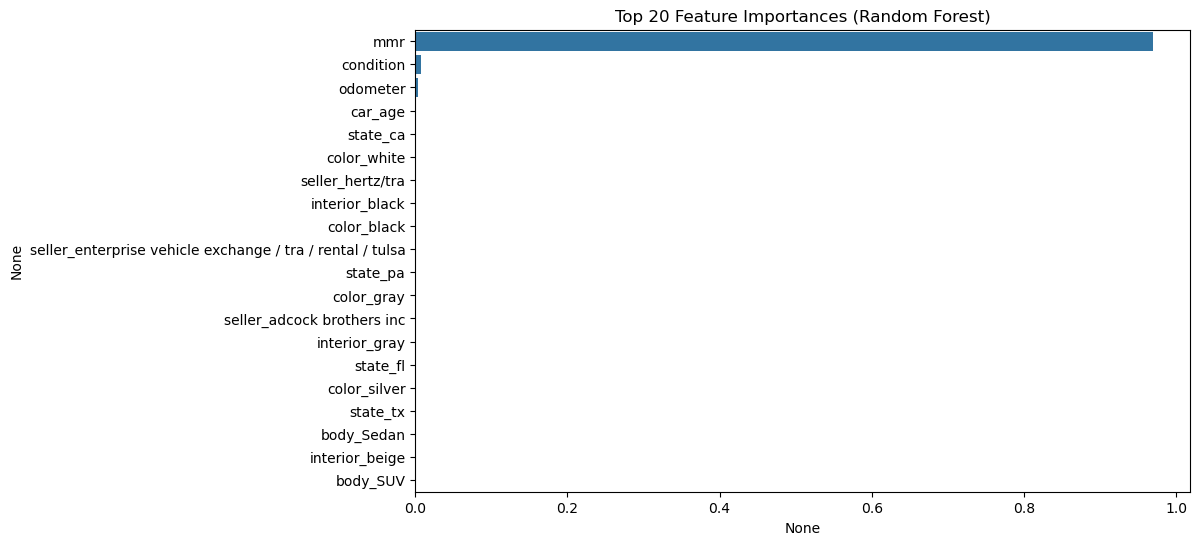

In [12]:

ohe_features = list(rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
all_features = numeric_features + ohe_features

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feat_importances = pd.Series(importances, index=all_features).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


In [13]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest'],
    'R2': [r2_score(y_test, y_pred_lr),
           r2_score(y_test, y_pred_ridge),
           r2_score(y_test, y_pred_lasso),
           r2_score(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
             np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
             np.sqrt(mean_squared_error(y_test, y_pred_rf))]
})
print(results)


               Model        R2         RMSE
0  Linear Regression  0.970640  1673.748903
1              Ridge  0.971063  1661.646020
2              Lasso  0.970665  1673.044796
3      Random Forest  0.972024  1633.826227


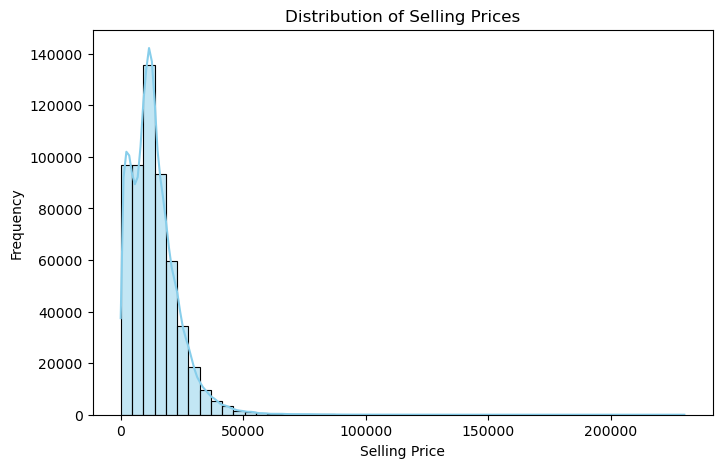

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['sellingprice'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()


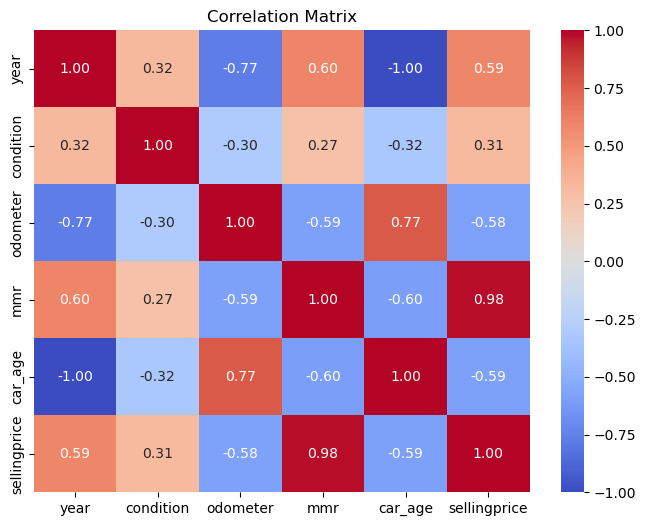

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['year','condition','odometer','mmr','car_age','sellingprice']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


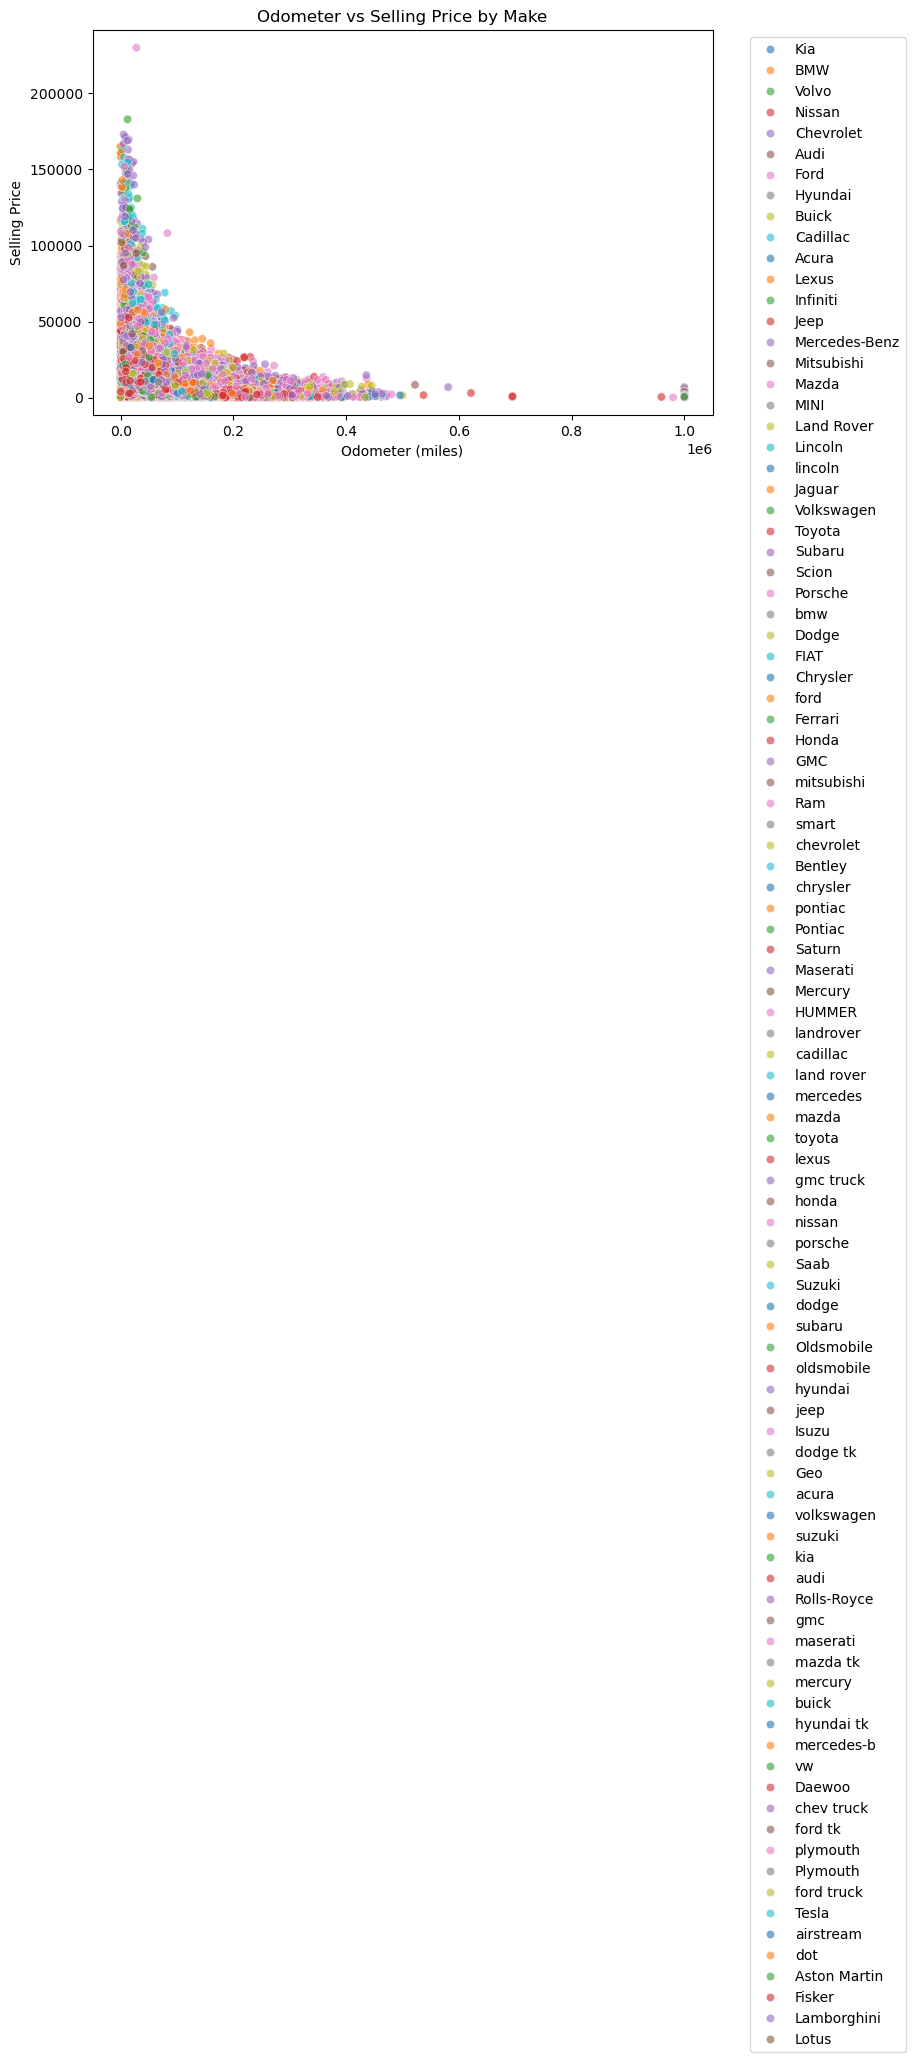

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='odometer', y='sellingprice', data=df, hue='make', palette='tab10', alpha=0.6)
plt.title("Odometer vs Selling Price by Make")
plt.xlabel("Odometer (miles)")
plt.ylabel("Selling Price")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


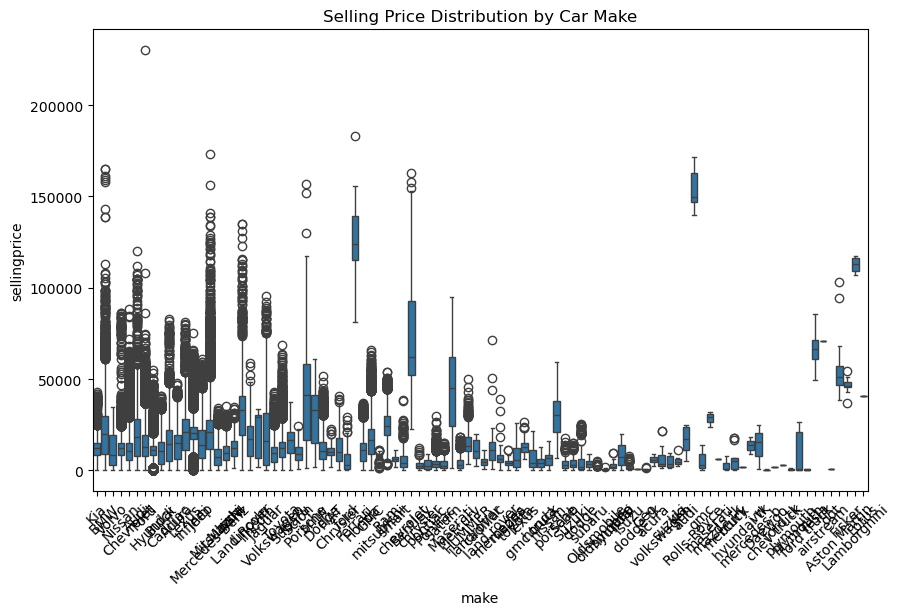

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x='make', y='sellingprice', data=df)
plt.xticks(rotation=45)
plt.title("Selling Price Distribution by Car Make")
plt.show()


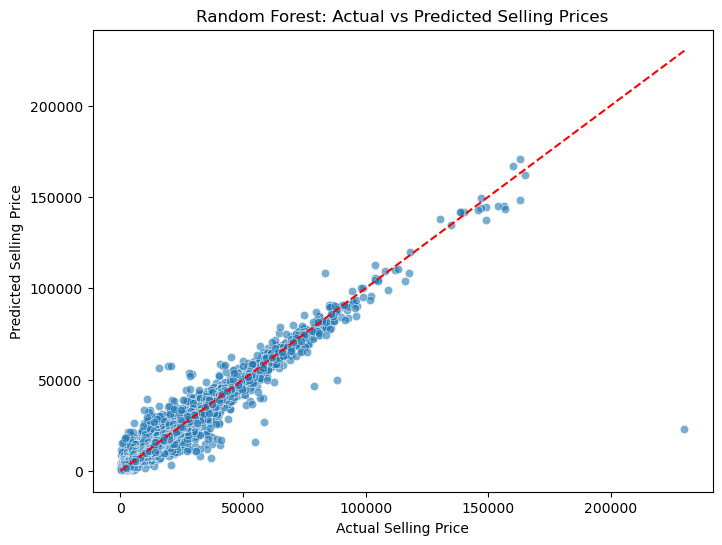

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Random Forest: Actual vs Predicted Selling Prices")
plt.show()


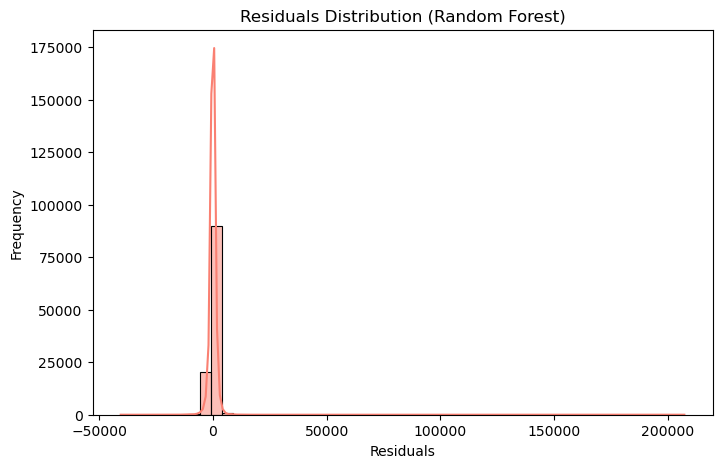

In [19]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color='salmon')
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_36984/3625642647.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances, y=feat_importances.index, palette='viridis')


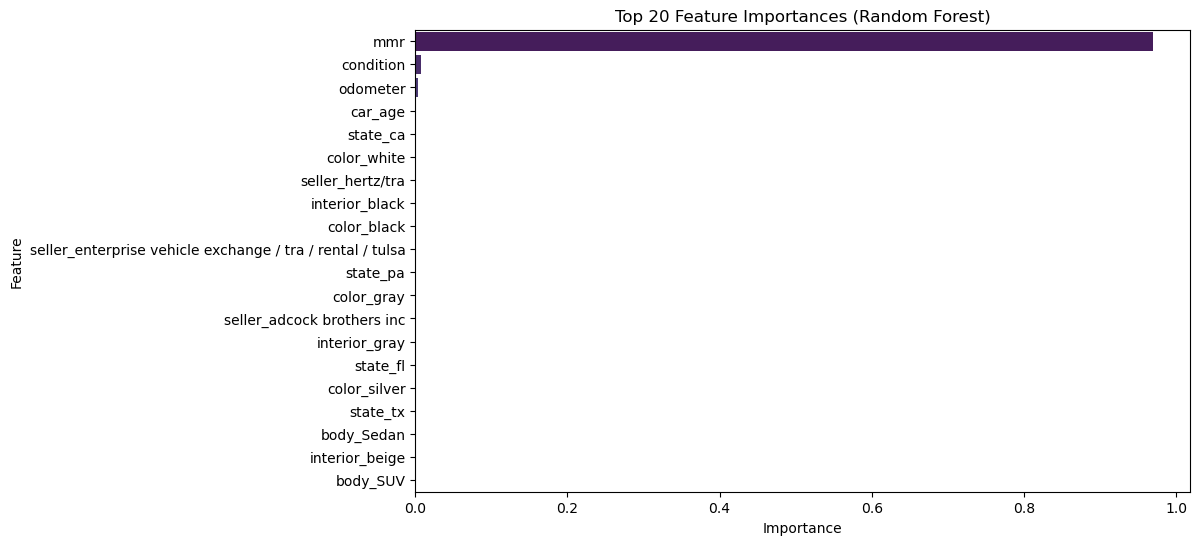

In [20]:
ohe_features = list(rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
all_features = numeric_features + ohe_features

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feat_importances = pd.Series(importances, index=all_features).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index, palette='viridis')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
